In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Enhance Imagen prompts with Gemini

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/vision/getting-started/prompt_generation_with_gemini.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Run in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fgenerative-ai%2Fmain%2Fvision%2Fgetting-started%2Fprompt_generation_with_gemini.ipynb">
      <img width="32px" src="https://cloud.google.com/ml-engine/images/colab-enterprise-logo-32px.png" alt="Google Cloud Colab Enterprise logo"><br> Run in Colab Enterprise
    </a>
  </td>    
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/vision/getting-started/prompt_generation_with_gemini.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/vision/getting-started/prompt_generation_with_gemini.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
</table>


| | |
|-|-|
|Author(s) | [Katie Nguyen](https://github.com/katiemn) |

## Overview

### Gemini 1.5 Pro

Gemini 1.5 Pro is a new language model from the Gemini family. This model introduces a long context window of up to 2 million tokens that can seamlessly analyze large amounts of information. Additionally, it is multimodal with the ability to process text, images, audio, video, and code. Learn more about [Gemini 1.5](https://blog.google/technology/ai/google-gemini-next-generation-model-february-2024/).

### Imagen 3

Imagen 3 on Vertex AI brings Google's state of the art generative AI capabilities to application developers. Imagen 3 is Google's highest quality text-to-image model to date. It's capable of creating images with astonishing detail. Thus, developers have more control when building next-generation AI products that transform their imagination into high quality visual assets. Learn more about [Imagen on Vertex AI](https://cloud.google.com/vertex-ai/generative-ai/docs/image/overview).


In this tutorial, you will learn how to use the Vertex AI SDK for Python to interact with Gemini 1.5 Pro and Imagen 3 to:

- Optimize your image generation prompts with Gemini based on a subject, action, scene, and style
- Rewrite your prompt based on good example prompts
- Generate enhanced prompts from an initial image

## Get Started


### Install Vertex AI SDK for Python


In [34]:
%pip install --upgrade --user --quiet google-cloud-aiplatform

### Restart runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which restarts the current kernel.

The restart might take a minute or longer. After it's restarted, continue to the next step.

In [ ]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. ⚠️</b>
</div>


### Authenticate your notebook environment (Colab only)

If you are running this notebook on Google Colab, run the following cell to authenticate your environment.


In [1]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

### Set Google Cloud project information and initialize Vertex AI SDK

To get started using Vertex AI, you must have an existing Google Cloud project and [enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com).

Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).

In [2]:
# Use the environment variable if the user doesn't provide Project ID.
import os

import vertexai

PROJECT_ID = "[your-project-id]"  # @param {type: "string", placeholder: "[your-project-id]", isTemplate: true}
if not PROJECT_ID or PROJECT_ID == "[your-project-id]":
    PROJECT_ID = str(os.environ.get("GOOGLE_CLOUD_PROJECT"))

LOCATION = os.environ.get("GOOGLE_CLOUD_REGION", "us-central1")

vertexai.init(project=PROJECT_ID, location=LOCATION)

### Import libraries


In [3]:
from vertexai.generative_models import GenerativeModel, Image, Part
from vertexai.preview.vision_models import ImageGenerationModel

### Load the Gemini 1.5 Pro and Imagen 3 models


In [4]:
model = GenerativeModel("gemini-1.5-pro")
image_generation_model = ImageGenerationModel.from_pretrained("imagen-3.0-generate-001")

### Define helper functions

In [5]:
import typing

import IPython.display
from IPython.display import display
from PIL import Image as PIL_Image
from PIL import ImageOps as PIL_ImageOps


def display_image(
    image: Image,
    max_width: int = 600,
    max_height: int = 350,
) -> None:
    pil_image = typing.cast(PIL_Image.Image, image._pil_image)
    if pil_image.mode != "RGB":
        # RGB is supported by all Jupyter environments (e.g. RGBA is not yet)
        pil_image = pil_image.convert("RGB")
    image_width, image_height = pil_image.size
    if max_width < image_width or max_height < image_height:
        # Resize to display a smaller notebook image
        pil_image = PIL_ImageOps.contain(pil_image, (max_width, max_height))
    IPython.display.display(pil_image)


def get_url_from_gcs(gcs_uri: str) -> str:
    # Converts GCS uri to url for image display
    url = "https://storage.googleapis.com/" + gcs_uri.replace("gs://", "").replace(
        " ", "%20"
    )
    return url

### Optimize your prompt

Input a subject, action, and scene you would like to generate. The Gemini prompt will expand these initial ideas, but provide as much detail as possible. Choose a style from the list for your image as well.

In [ ]:
subject = ""  # @param {type:"string"}
action = ""  # @param {type:"string"}
scene = ""  # @param {type:"string"}
style = "photorealistic"  # @param ["photorealistic", "illustration", "digital", "minimalist", "vintage photo", "abstract", "cinematic"]

prompt = """
Use the provided subject, action, scene, and style
to produce a descriptive prompt that can be used to generate an image
with a text-to-image model.

Specify where the subject is situated within the image.

Indicate how the light plays a role in the image.

Only return the prompt string.
"""

contents = [subject, action, scene, style, prompt]

responses = model.generate_content(contents)
display(IPython.display.Markdown("***Prompt:*** " + responses.text))

# generate image from Gemini written prompt
images = image_generation_model.generate_images(
    prompt=responses.text,
    number_of_images=1,
    aspect_ratio="1:1",
    safety_filter_level="block_few",
    person_generation="allow_adult",
)

display_image(images[0])

### Rewrite your prompt

You can also use Gemini to rewrite an entire prompt. Enter your prompt in ```user_prompt```. You can be as detailed or as simple as you would like. This prompt enhances your initial prompt based on some provided gold standard sample prompts. You can edit the 5 example prompts below to better match your own use cases for more tailored results. See the next section for more details.

In [ ]:
user_prompt = ""  # @param {type:"string"}

prompt = """
I will provide some example prompts for image generation.

1. Science fiction spacesuit, white and green color scheme,
highly detailed, intricate, full body armor, futuristic, tactical,
dark gray background, front view, upper body, 3d render.

2. A woman in profile view, gazing into the distance, against a backdrop of a vibrant,
swirling nebula of magenta and purple hues. Superimposed over the nebula
is a web of interconnected nodes, each housing a distinct social media icon. The centerpiece of this web is a
banner proclaiming "FUTURE OF MESSAGING" in bold, futuristic font.

3. A large, round, modern coffee table made of light oak wood sits in a dimly
lit, minimalist room with dark gray walls. The table has four thick,
cylindrical legs that are evenly spaced. An open magazine with white pages
rests on the table's surface.  In the background, a simple chair with a round,
wooden seat and a black metal frame is slightly out of focus. The floor is a
medium gray concrete with subtle light reflections.

4. A stylish man stands before the New York City skyline, bathed in the golden
light of a late afternoon. He is wearing a green polo shirt with the top
button fastened. Over the polo, he wears a light brown, unzipped bomber jacket.
His dark brown hair is styled with a relaxed wave. He is looking down,
a contemplative expression on his face.

5. A perfume bottle with a golden cap standing on a white surface,
hit by natural window light creating a sharp shadow on the right.
The bottle is rectangular, made of clear glass and contains a light
amber-colored fragrance. The background is a simple white wall.

Consider these prompts. Based on these examples, rewrite the user provided
prompt in a similar format.
"""

contents = [user_prompt, prompt]

responses = model.generate_content(contents)
display(IPython.display.Markdown("***Prompt:*** " + responses.text))

# generate image from Gemini written prompt
images = image_generation_model.generate_images(
    prompt=responses.text,
    number_of_images=1,
    aspect_ratio="1:1",
    safety_filter_level="block_few",
    person_generation="allow_adults",
)

display_image(images[0])

### Generate elaborate prompts from images

To get more example prompts you can supply images that fit your use case and have Gemini write a prompt for the provided image. Modify ```gcs_uri``` to point to your image in Google Cloud Storage.

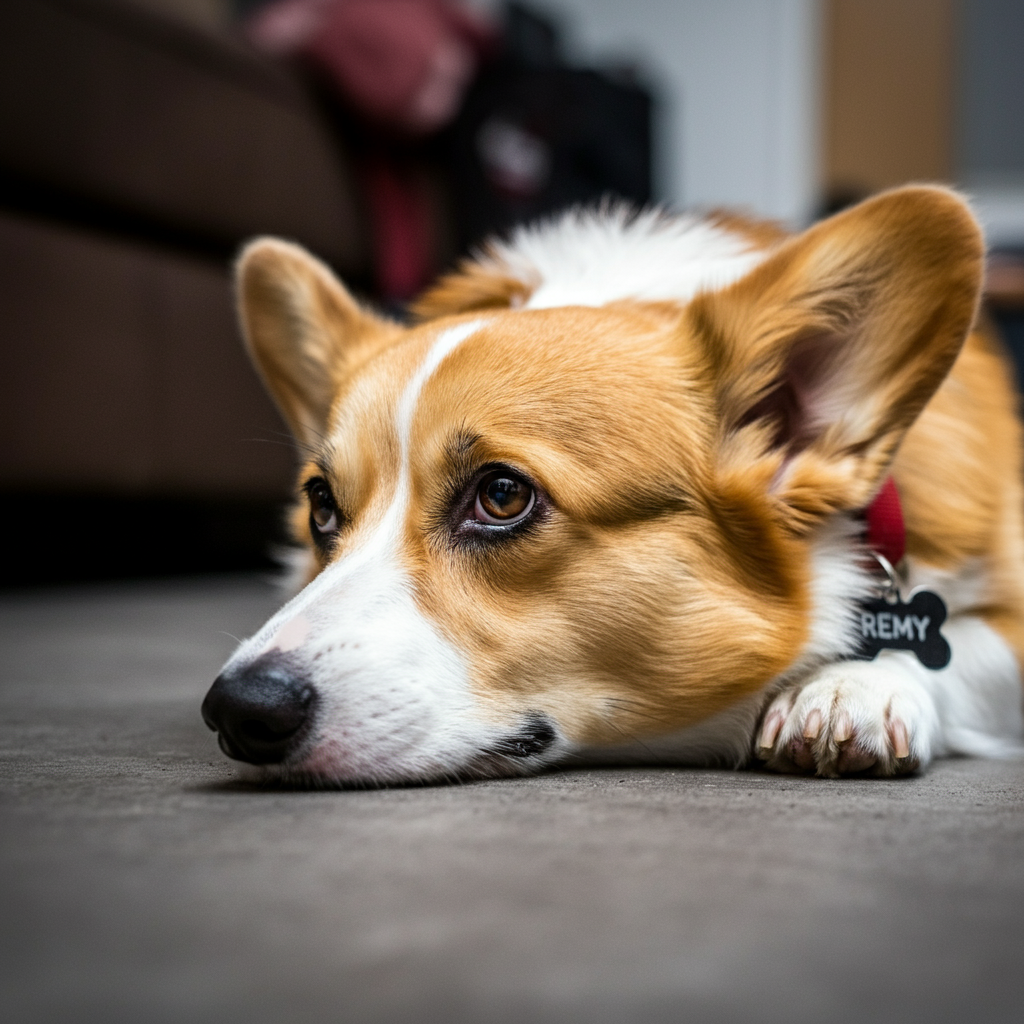

In [11]:
# Load an image from Google Cloud Storage
gcs_uri = (
    "gs://cloud-samples-data/generative-ai/image/dog-ad-1.png"  # @param {type:"string"}
)
example_image = Part.from_uri(gcs_uri, mime_type="image/png")

# Display image
url = get_url_from_gcs(example_image.file_data.file_uri)
IPython.display.Image(url, width=350)

Run the following cell to generate a detailed prompt-like description of the previous image. This output can be copied and pasted into the Gemini prompt in the "Rewrite your prompt" section as a gold standard prompt. Each prompt that you add/replace in that section will help tailor the style of the rewritten prompts.

In [12]:
gemini_prompt = """
Based on the provided image, create a highly detailed prompt for a text-to-image model.
Combine all attributes into a statement of the most important attributes.
Include extra details where necessary and make sure to include details and words in the image.
"""

contents = [gemini_prompt, example_image]

responses = model.generate_content(contents)
display(IPython.display.Markdown("***Prompt:*** " + responses.text))

***Prompt:*** A close-up photo of a pensive Pembroke Welsh Corgi named "Remy" lying on a gray carpeted floor. Remy's head is resting on the floor, with his chin slightly raised and big, soulful eyes looking directly at the viewer. He has a worried expression. He has a red collar with a black tag that says "Remy" in white letters. The background is blurred, but appears to be a living room setting with a brown couch visible. Focus is on the dog's eyes and expression. Use a shallow depth of field. 
